In [347]:
from typing import List, Dict, Tuple
from tqdm.auto import tqdm
import random
import os
import json
import re
from re import finditer
from itertools import tee
import pickle
import urllib
from collections.abc import Iterable, Iterator

### Utils

def g_path(*argv: str)->str:
    """short hand for creating a new path properly
    args:
        argv: vector of strings to join into a path"""
    return os.path.join(*argv)

def pairwise(iterable:Iterable)->Iterator:
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def camel_case_split(identifier):
    matches = finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

vocab = json.load(open("../CHIIR21-SAL-Scaffolding/data/vocab.json"))
topics = {x['title']:k for k,x in vocab.items() if x['title'] != "Sports" and x['title']!="Norepinephrine" and x['title']!="Research in lithium-ion batteries"}

subtopics = json.load(open("../CHIIR21-SAL-Scaffolding/data/topics.json"))
subtopics = {x['title'] :x['terms'] for x in subtopics.values() if x['title'] != "Sports" and x['title']!="Norepinephrine" and x['title']!="Research in lithium-ion batteries"}
subtopics["Ethics"]["Meta-ethics"] = subtopics["Ethics"].pop("Meta ethics")

subtopics ={k: list(map(lambda x: urllib.parse.quote(x) , v.keys())) for k, v in subtopics.items()}  # Dict[topic_name, List[subtopic]] , Dict[str, List[str]]
subtopics_keywords = pickle.load(open("../data/subtopic_l2_keywords.pkl", 'rb'))  # Dict[subtopic, Set[keywords]], Dict[str, Set[str]]
methods = {x.split("_")[0] for x in os.listdir(simulation_output_folder) if x!="COMPLETED"}

params = {"lambda": [0.1, 0.4, 0.8],
          "limit": [2.0, 6.0, 10.0],
          "threshold":[0.0, 1.0, 3.0, 5.0]
         }

all_users = list(product(params['limit'], params['threshold'], params['lambda']))


In [348]:
#Mappings
topics = {
    "ethics": 1,
    "genetically_modified_organism": 2,
    "noise-induced_hearing_loss": 3,
    "subprime_mortgage_crisis": 4,
    "radiocarbon_dating_considerations": 5,
    "business_cycle": 7,
    "irritable_bowel_syndrome": 8,
    "theory_of_mind": 9
}

subtopic_strategies = {
    "Greedy": 1,
    "Random": 2,
    "Reverse": 3,
    "GreedySmart": 4
}

In [349]:
#THIS IS LONG AF
HOME_PATH = "data/simulation_data"


def get_file_name(subtopic_strategy, limit, sn_threshold, sn_lambda,doc_lambda, topic, extension, run_id):
    limit = f"{str(limit).replace('.', '')}"
    sn_threshold = f"{str(sn_threshold).replace('.', '')}"
    sn_lambda = f"{str(sn_lambda).replace('.', '')}"
    doc_lambda = f"{str(doc_lambda).replace('.', '')}"

    partial_filename = f"run_{run_id}_sub{subtopic_strategy}-l{limit}_q13_ss1_se0_sn0-t{sn_threshold}l{sn_lambda}_doc0-l{doc_lambda}"
    run_file_template = f"{HOME_PATH}/run_{run_id}_sub{subtopic_strategy}/vars-l{limit}/q13/ss1/se0/sn0/vars-t{sn_threshold}l{sn_lambda}/doc0/vars-l{doc_lambda}/output/{partial_filename}-{topic}-user-{partial_filename}.{extension}"

    return run_file_template


a = get_file_name(1, 10.0, 5.0, 0.8, 0.1, "ethics", "log",1)
os.path.isfile(a)

True

In [351]:
#Take the weight of each topic, according to the number of subtopics
number_of_keywords_per_topic = dict()
for topic in subtopics.keys():
    encoded_topic_name = urllib.parse.quote(topic)
    topic_subtopics = ["/".join((encoded_topic_name, x)) for x in subtopics[topic]]
    all_keywords = set.union(*[subtopics_keywords[v] for v in topic_subtopics if v in subtopics_keywords])
    number_of_keywords_per_topic[topic] = len(all_keywords)

max_subtopic_keywords = max(number_of_keywords_per_topic.values())
normalization_factors = {k:v/max_subtopic_keywords for (k, v) in number_of_keywords_per_topic.items()}

local_cache = {}

In [352]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.porter import *
stemmer = PorterStemmer()


stop_words = set(stopwords.words("english"))
pattern = re.compile("([^\s\w]|_)+")


import redis
db_url = redis.Redis(db=10, decode_responses=True)
def get_document_content(doc_url):
    if doc_url in db_url:
        return db_url.get(doc_url)
    return ""

def get_doc_keywords(doc, keywords):
    doc = get_document_content(doc)
    clean_doc = pattern.sub(" ", doc)
    clean_doc = [stemmer.stem(w.lower()) for w in clean_doc.split() if (w not in stop_words and stemmer.stem(w) in keywords)]
    return Counter(clean_doc)


In [398]:
def completed_per_doc(file_name, keywords, topic, threshold):
    list_of_keywords = terms_order[topic]
    lm_file = file_name.replace("log", "lms.json")
    lms = json.load(open(lm_file))['GLOBAL']
    prev_lm = {k:v for k, v in lms[0].items() if v > 3}
    validated_keywords = set([stemmer.stem(x) for x in prev_lm.keys()]) #all terms learned so far.Initialize with first LM.
    return_list = [len(validated_keywords)]
    docs_read = []
    for line in open(file_name):
        if not line.split()[1] == "DOC":
            continue
        url = line.strip().split()[-1]
        docs_read.append(url)
    for url in docs_read:
        try:
            doc_keywords = local_cache[(url, topic)]
        except KeyError:
            doc_keywords = get_doc_keywords(url, keywords)
            local_cache[(url, topic)] = doc_keywords
        added_keywords = {stemmer.stem(k) for k in doc_keywords.keys() if k not in validated_keywords}
        for k in added_keywords:
            k_index = list_of_keywords.index(k)
            necessary_learned_keywords = len([x for x in list_of_keywords[:k_index] if x in validated_keywords.union(added_keywords)])

            if necessary_learned_keywords/(k_index+1) >=threshold:
                validated_keywords.add(k)
        return_list.append(len(validated_keywords))
    return [x/len(list_of_keywords) for x in return_list]


def completed_subtopics_per_agent(limit, lam, threshold, topic, method,  n_runs):
    method_id = subtopic_strategies[method]
    c_topic =  topic.lower().replace(" ", "_")
    encoded_topic_name = urllib.parse.quote(topic)
    topic_subtopics = ["/".join((encoded_topic_name, x)) for x in subtopics[topic]]
    all_keywords = set.union(*[subtopics_keywords[v] for v in topic_subtopics if v in subtopics_keywords])
    all_runs = []
    for r in range(n_runs):
        file_name = get_file_name(method_id, limit, threshold, lam, doc_lambda, c_topic, "log", r)
        all_runs.append(completed_per_doc(file_name, all_keywords, topic, 0.3))
    
    # pad if needed
    longest_value = max([len(x) for x in all_runs])
    for i in range(n_runs):
        if len(all_runs[i]) < longest_value:
            last_value = all_runs[i][-1]
            all_runs[i].extend([last_value] * (longest_value - len(all_runs[i])))
    # get the mean over all runs
    mean_ys = []
    for i in range(max([len(x) for x in all_runs])):
        mean_ys.append(np.mean([x[i] for x in all_runs]))
    return mean_ys


In [412]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.porter import *
stemmer = PorterStemmer()


stop_words = set(stopwords.words("english"))
pattern = re.compile("([^\s\w]|_)+")

def get_doc_keywords(doc, keywords):
    doc = get_document_content(doc)
    clean_doc = pattern.sub(" ", doc)
    clean_doc = [stemmer.stem(w.lower()) for w in clean_doc.split() if (w not in stop_words and stemmer.stem(w) in keywords)]
    return Counter(clean_doc)
        


set()


  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

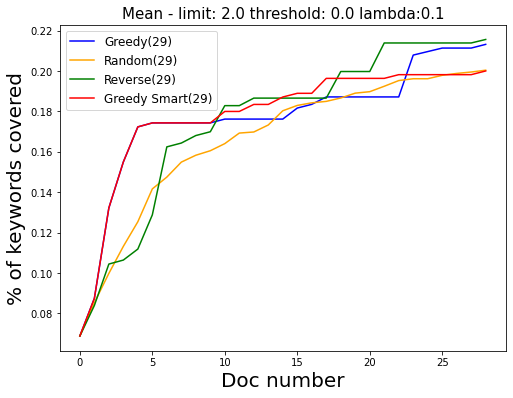

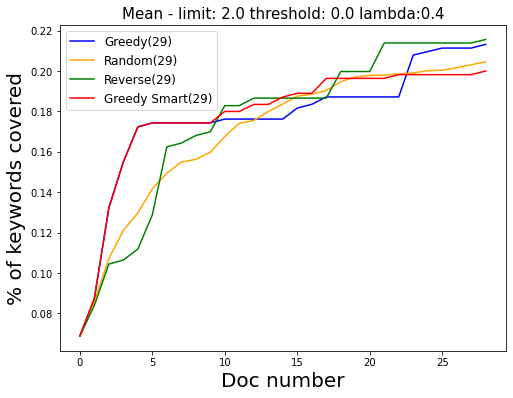

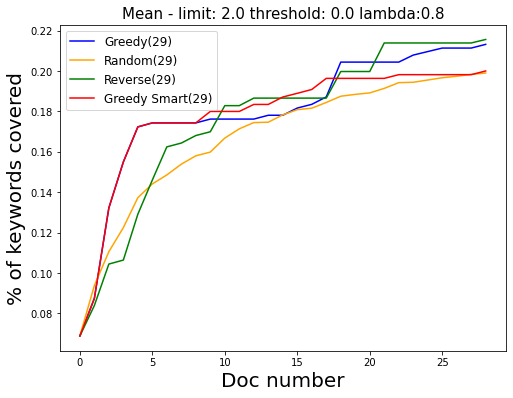

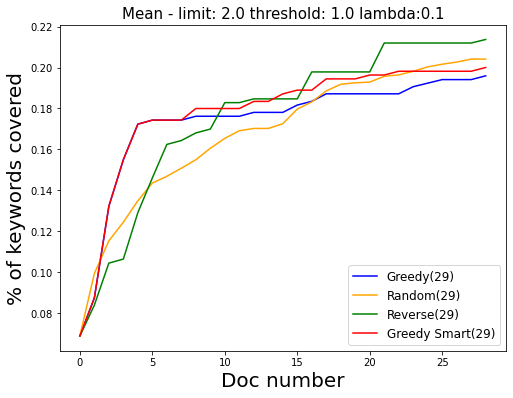

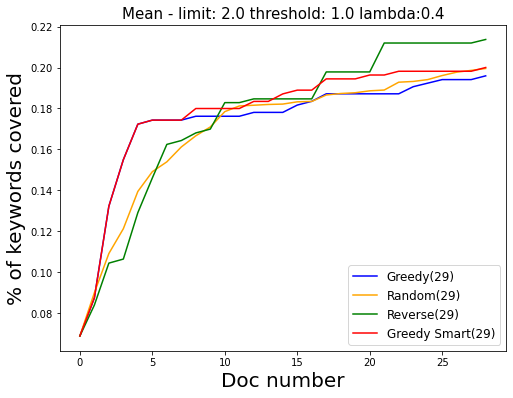

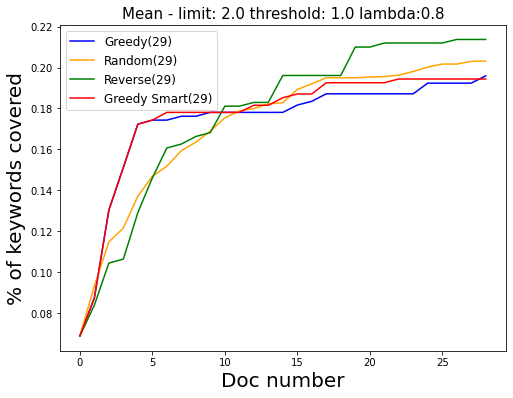

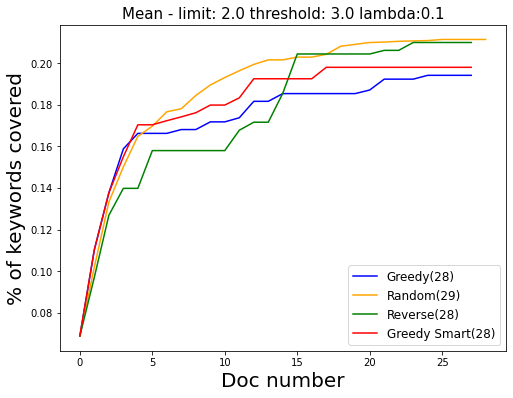

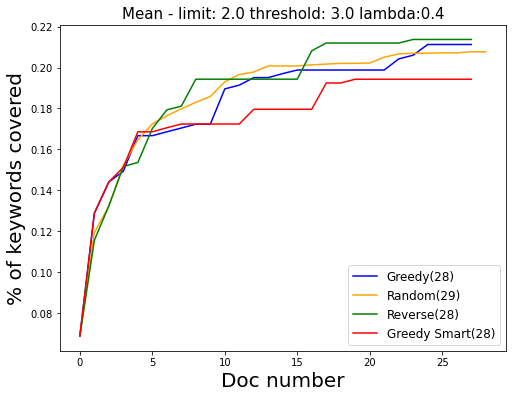

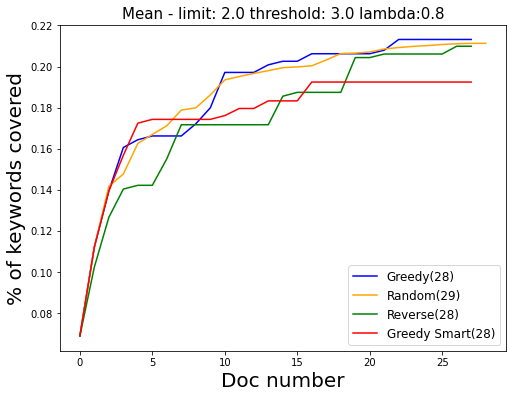

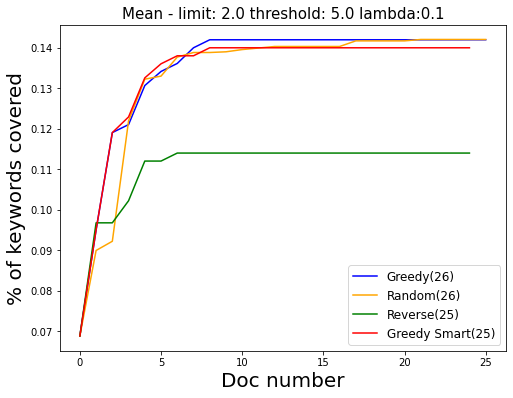

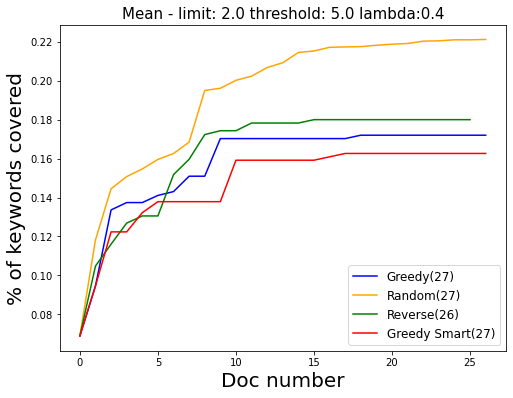

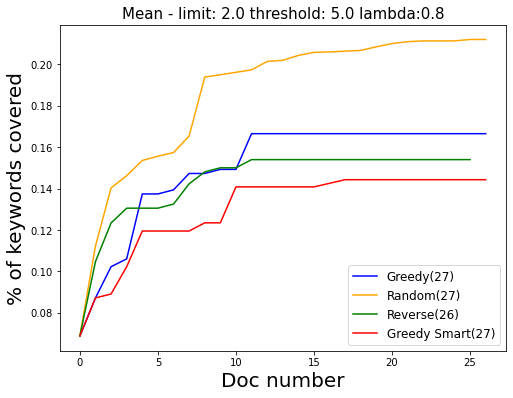

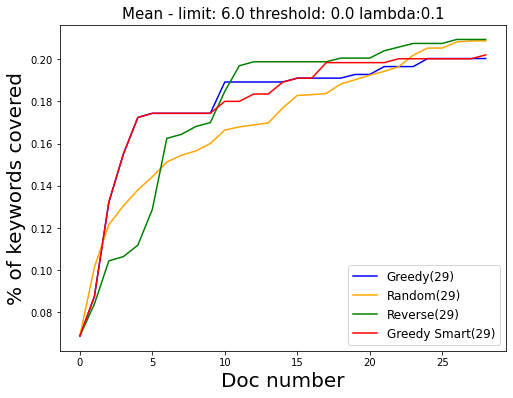

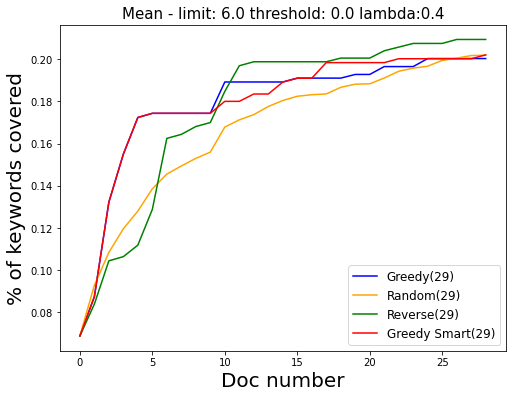

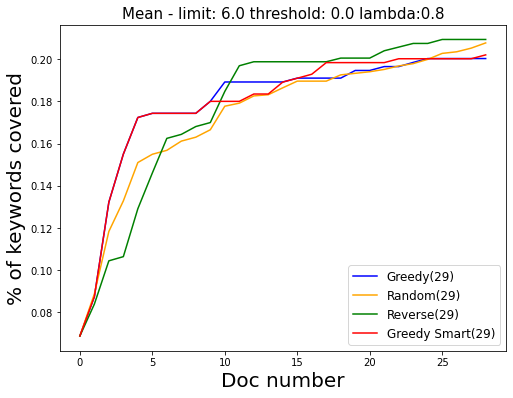

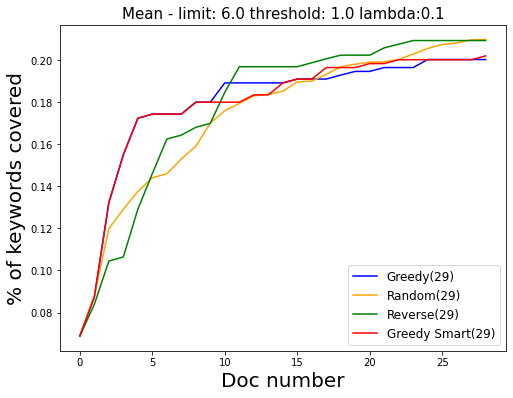

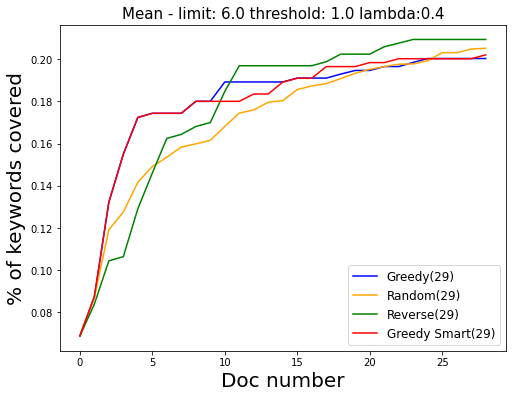

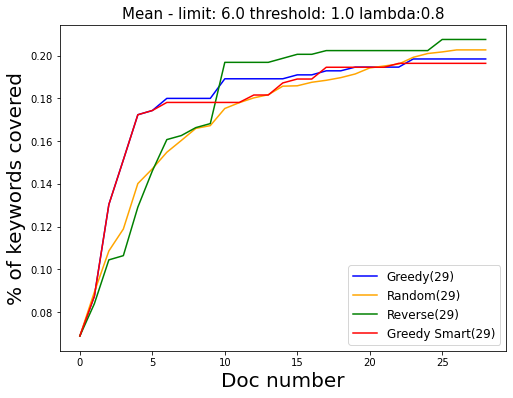

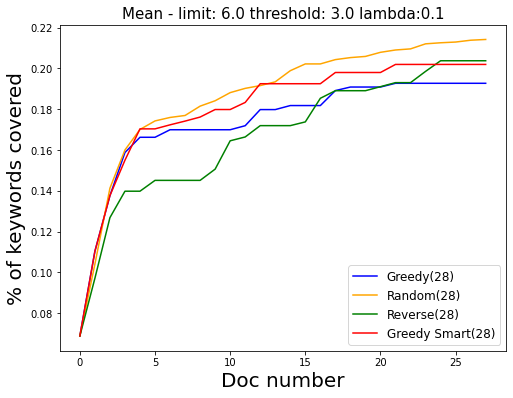

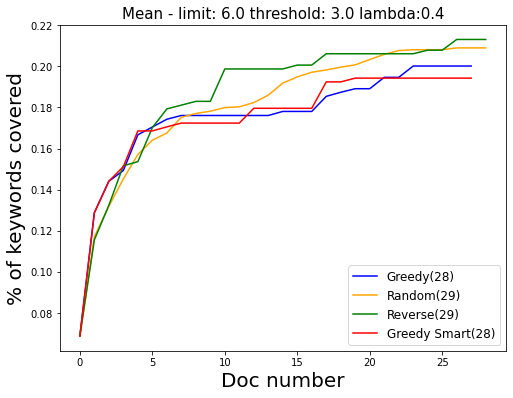

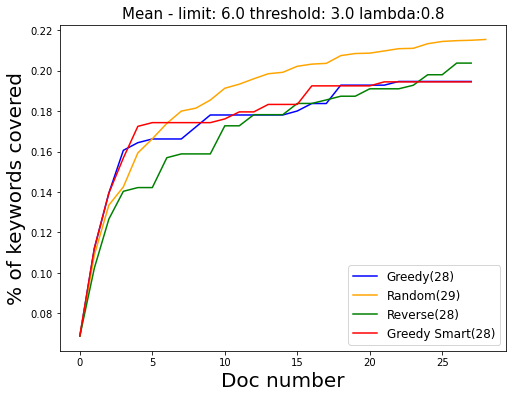

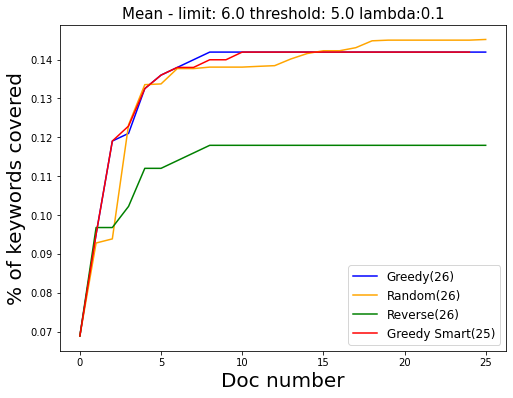

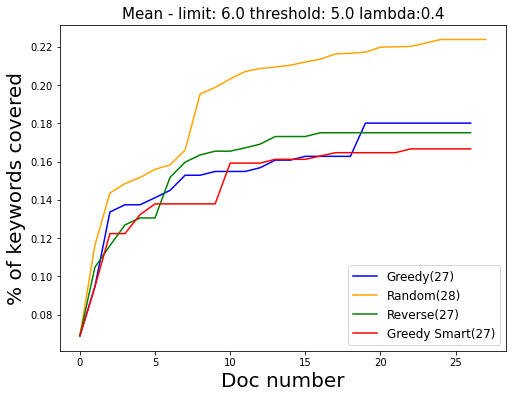

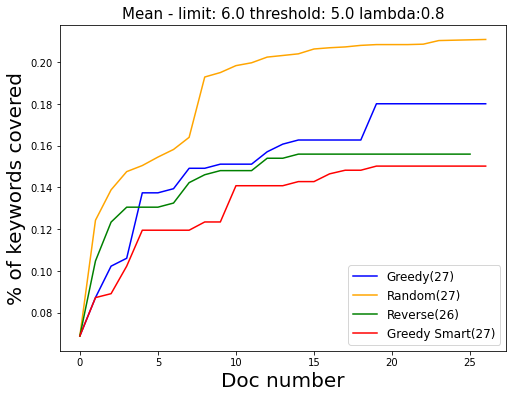

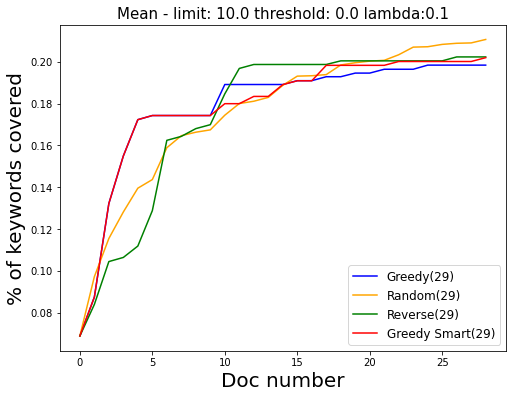

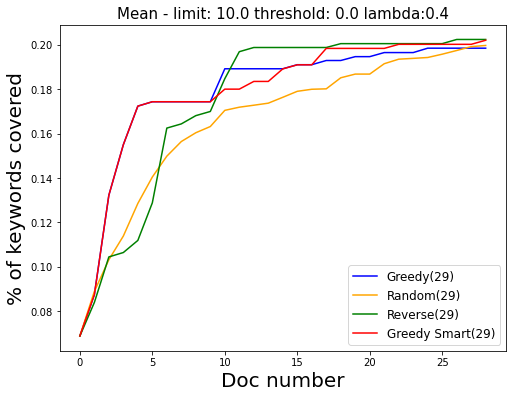

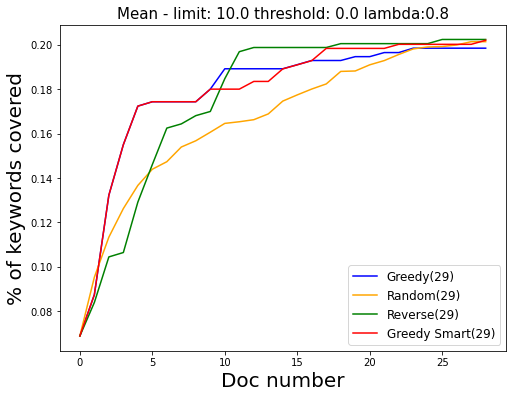

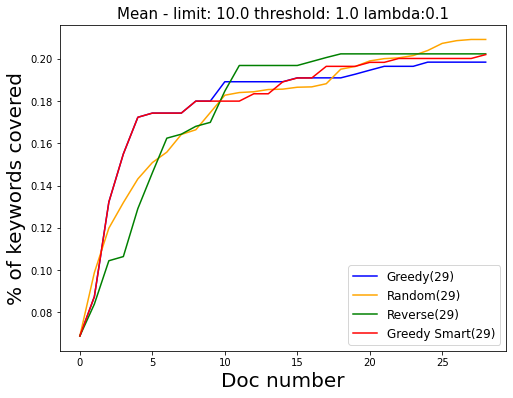

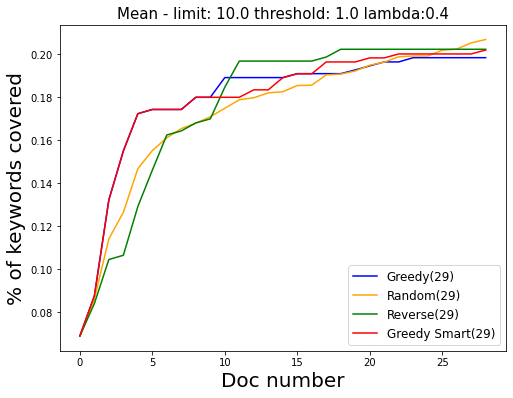

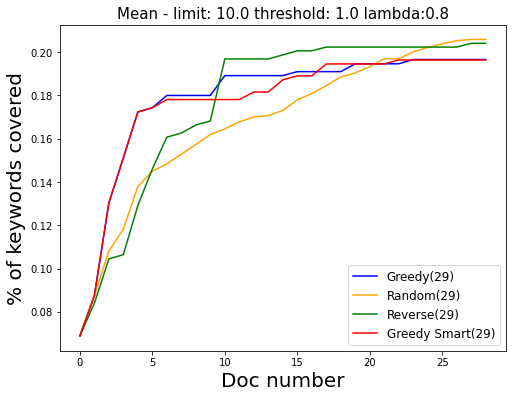

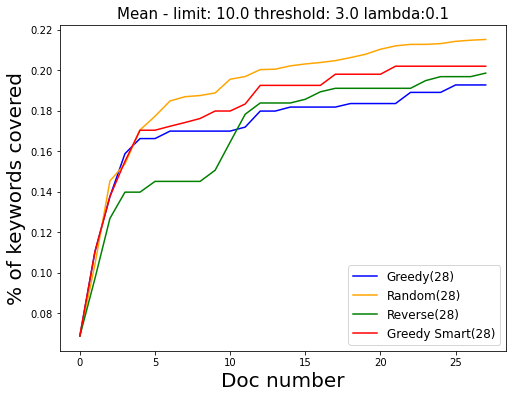

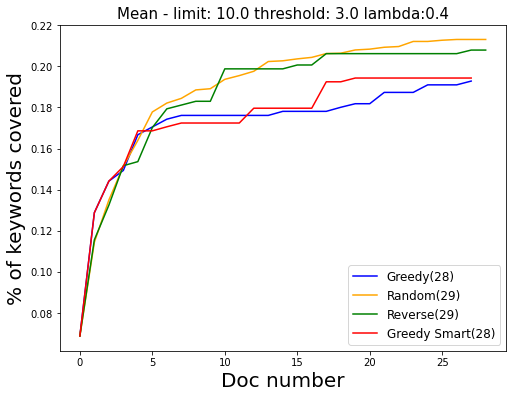

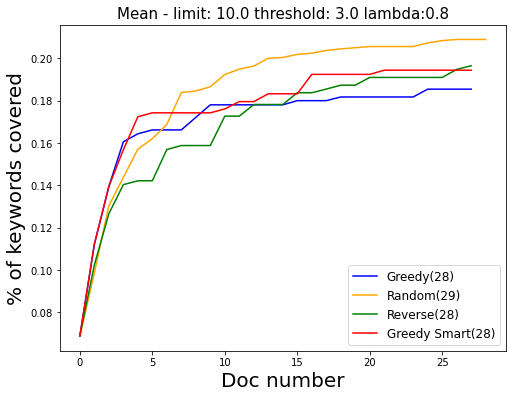

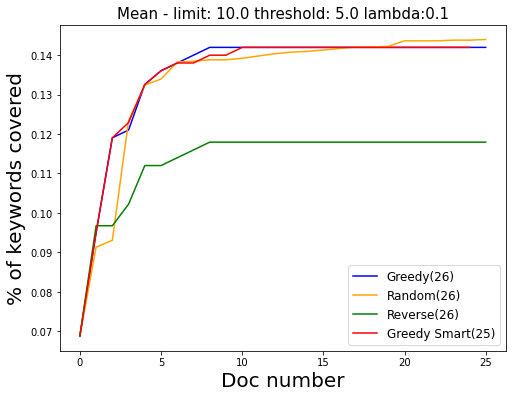

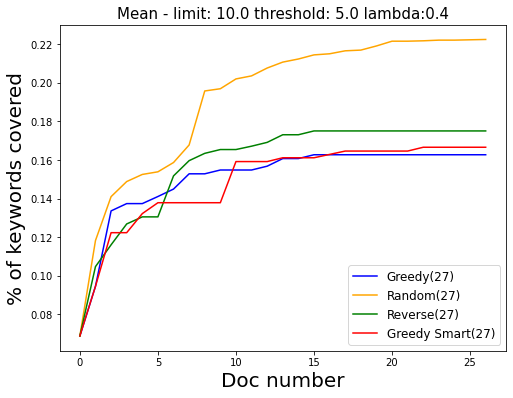

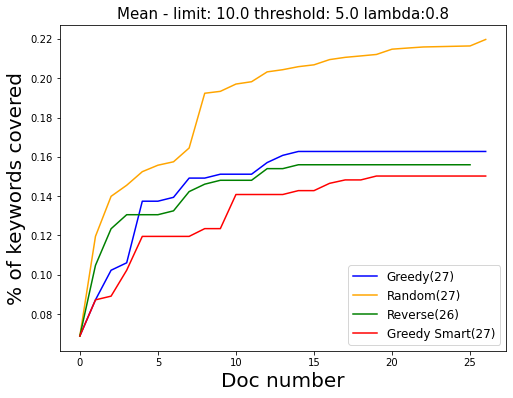

In [413]:
# %matplotlib inline

subtopic = "GLOBAL"

colors = {"Greedy": "blue", "Random": "orange", "Reverse": "green", "GreedySmart": "red"}
    
doc_lambda= 0.1 #FIXED


min_count = 10

prev_lm = defaultdict(lambda:0.0)

pbar = tqdm(total=27*len(subtopics)*len(subtopic_strategies))

for idx, (limit, threshold, lam) in tqdm(enumerate(all_users), total=27):
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"plots/Ordered_keywords/Ordered_keyword-Limit-{limit}_Lambda-{lam}_Threshold-{threshold}.pdf")
    all_ys = defaultdict(lambda:defaultdict(lambda:[]))
    for topic in subtopics.keys():
        fig = figure(figsize=(8, 6))
        encoded_topic_name = urllib.parse.quote(topic)
        for method in subtopic_strategies.keys():
            pbar.update()
            y_values = completed_subtopics_per_agent(limit, lam, threshold, topic, method,  10)
            x_values = list(range(len(y_values)))
            all_ys[method][topic]=y_values
            plt.plot(x_values, y_values, label=" ".join(camel_case_split(method))+f"({len(y_values)-1})", c=colors[method])
            
        plt.xlabel(f"Doc number", fontsize=20)
        plt.title(topic, fontsize=15)
        plt.ylabel("% of keywords covered", fontsize=20)
        plt.legend(fontsize=12)
        pdf.savefig(fig)
        plt.close()
    #Create the mean plots
    fig = figure(figsize=(8, 6))
    for method in all_ys:
        longest_session = max(map(len, all_ys[method].values()))
        for topic in all_ys[method]:
            padding_needed = longest_session - len(all_ys[method][topic])
            padding = [all_ys[method][topic][-1]] * padding_needed
            all_ys[method][topic] += padding

        # For this method, for each query number (longest_session), multiply by the respective normalization factor and take the mean
        mean_ys = []
        for i in range(longest_session):
            session_ys = []
            for topic in all_ys[method]:
                try:
                    session_ys.append(all_ys[method][topic][i]*normalization_factors[topic])
                except:
                    continue
            mean_ys.append(np.mean(session_ys))
        plt.plot(range(longest_session), mean_ys, label=" ".join(camel_case_split(method))+f"({len(mean_ys)})", c=colors[method])
    plt.xlabel(f"Doc number", fontsize=20)
    plt.title(f"Mean - limit: {limit} threshold: {threshold} lambda:{lam}", fontsize=15)
    plt.ylabel("% of keywords covered", fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    pdf.savefig(fig)
    plt.close() 
    pdf.close()
pbar.close()